In [1]:
import pandas as pd
import re
import string
from transformers import pipeline
from transformers import AutoTokenizer,AutoModelForSequenceClassification
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [4]:
#Αρχικοποίηση του μοντέλου "cardiffnlp/twitter-roberta-base-sentiment" για την ανάλυση συναισθημάτων.
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline("sentiment-analysis",model=model, tokenizer=tokenizer)



# Φόρτωση δεδομένων
data = pd.read_csv('train_2019')
data23 = pd.read_csv('train_2023')


C:\Users\giorg\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
# Συνάρτηση για την προεπεξεργασία δεδομένων
def preprocess_text(text):
    text = text.lower()  # μετατροπή σε μικρούς χαρακτήρες
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # αφαίρεση links
    text = re.sub(r'[^\w\s]', '', text)  # αφαίρεση σημείων στίξης
    text = re.sub(r'[^\x00-\x7F]+', '', text).strip()  # αφαίρεση μη λατινικών χαρακτήρων (π.χ. κινεζικά)
    text = re.sub(r'\s+', ' ', text).strip()  # αφαίρεση επιπλέον κενών


    return text

# Αφαίρεση των stop words από τη στήλη comments
data['comments'] = data['comments'].apply(preprocess_text)
data['comments'] = data['comments'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in ENGLISH_STOP_WORDS]))


# Μετατρέπουμε την στήλη σε strings
data23['comments'] = data23['comments'].astype(str)
#
# # Αφαίρεση των stop words από τη στήλη description
data23['comments'] = data23['comments'].apply(preprocess_text)
data23['comments'] = data23['comments'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in ENGLISH_STOP_WORDS]))

# Φιλτράρισμα των δεδομένων βάσει του μήκους του σχολίου ('comments')
data_filtered23 = data23[data23['comments'].str.len() <= 500]

#Eπιλογή 2000 τυχαίων δεδομένων απο το αρχείο train_2019
selected_columns = data.sample(n=2000, axis=0)
#Eπιλογή 2000 τυχαίων δεδομένων απο το αρχείο train_2023
selected_columns23 = data_filtered23.sample(n=2000, random_state=42)

# Διαγραφή των γραμμών με κενή τιμή στη στήλη 'comments'
selected_columns.dropna(subset=['comments'], inplace=True)
selected_columns23.dropna(subset=['comments'], inplace=True)

In [6]:
print("Done!")
# Εκτέλεση ανάλυσης συναισθήματος και αποθήκευση αποτελεσμάτων
results = []
results23 = []

# Εκτύπωσε τις στήλες "id" και "comment" παράλληλα
for index, row in selected_columns.iterrows():
    sentiment = classifier(row['comments'])

    results.append({
        'id': row['id'],
        'review': row['comments'],
        'sentiment': sentiment[0]['label']
    })

print("Data for 2019 done!")

for index, row in selected_columns23.iterrows():
    sentiment = classifier(row['comments'])

    results23.append({
        'id': row['id'],
        'review': row['comments'],
        'sentiment': sentiment[0]['label']
    })

print("Data for 2023 done!")

results_df = pd.DataFrame(results)
results23_df = pd.DataFrame(results23)
print("Done")

Done!
Data for 2019 done!
Data for 2023 done!
Done


In [7]:
# Αποθήκευση των αποτελεσμάτων σε CSV αρχείο
results_df.to_csv('reviews_with_sentiment.csv', index=False)
results23_df.to_csv('reviews_with_sentiment1.csv', index=False)

In [8]:
import pandas as pd
import re


data2019 = pd.read_csv('reviews_with_sentiment.csv')
data2023 = pd.read_csv('reviews_with_sentiment1.csv')
# Αντικατάσταση των NaN τιμών με κενές συμβολοσειρές
data2019['review'].fillna('', inplace=True)
data2023['review'].fillna('', inplace=True)
print("Done.")

Done.


C:\Users\giorg\AppData\Local\Temp\ipykernel_10760\462035416.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data2019['review'].fillna('', inplace=True)
C:\Users\giorg\AppData\Local\Temp\ipykernel_10760\462035416.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, w

In [9]:
# Φιλτράρουμε τις γραμμές με sentiment = LABEL_2
sentiment_zero2019 = data2019[data2019['sentiment'] == "LABEL_2"]
sentiment_zero2023 = data2023[data2023['sentiment'] == "LABEL_2"]

In [10]:
# Επιλέγουμε τυχαία το 50% από αυτές τις γραμμές
sentiment_zero_sample2019 = sentiment_zero2019.sample(frac=0.6, random_state=1)
sentiment_zero_sample2023 = sentiment_zero2023.sample(frac=0.6, random_state=1)

In [11]:
# Αφαιρούμε τις επιλεγμένες γραμμές από το αρχικό DataFrame
data2019 = data2019.drop(sentiment_zero_sample2019.index)
data2023 = data2023.drop(sentiment_zero_sample2023.index)

In [12]:
for index, rows in data2019.iterrows():
    if rows['sentiment'] == "LABEL_2":
       data2019.at[index, 'sentiment'] = "POSITIVE"
    elif rows['sentiment'] == "LABEL_0":
        data2019.at[index, 'sentiment'] = "NEGATIVE"
    else:
        data2019.at[index, 'sentiment'] = "NEUTRAL"

for index, rows in data2023.iterrows():
    if rows['sentiment'] == "LABEL_2":
       data2023.at[index, 'sentiment'] = "POSITIVE"
    elif rows['sentiment'] == "LABEL_0":
        data2023.at[index, 'sentiment'] = "NEGATIVE"
    else:
        data2023.at[index, 'sentiment'] = "NEUTRAL"

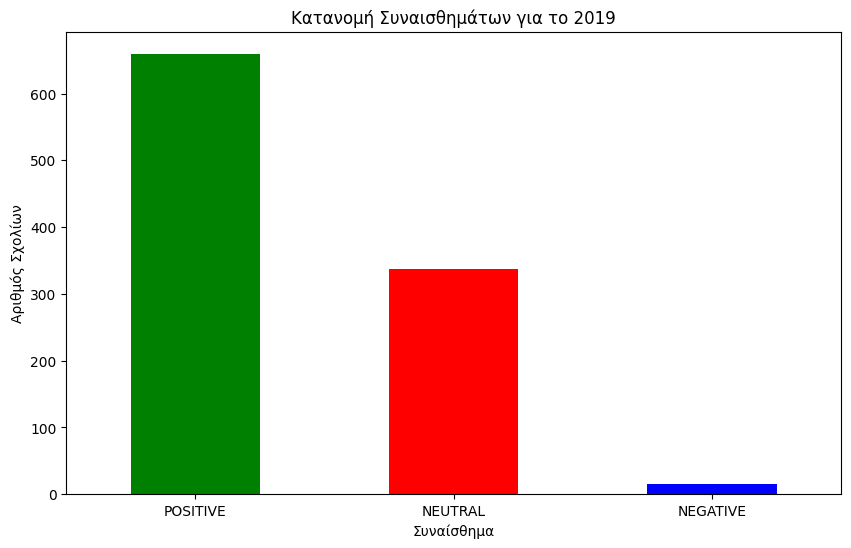

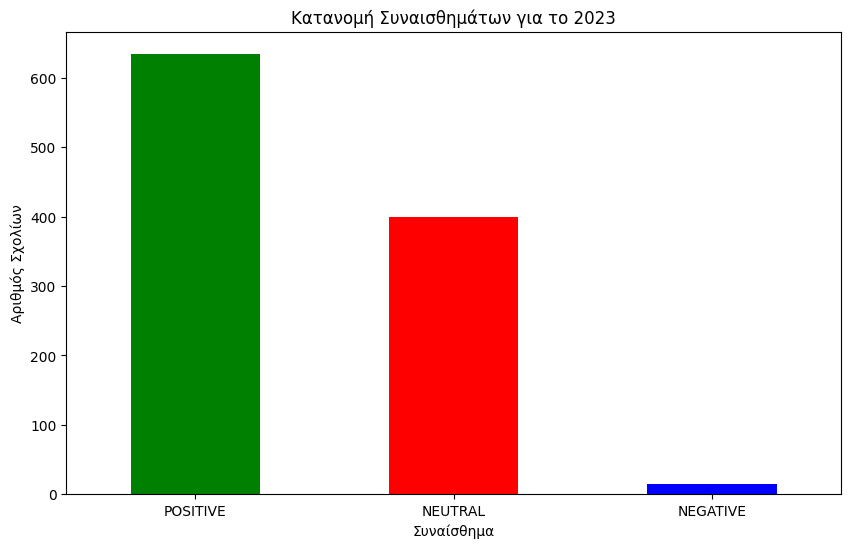

In [25]:
import matplotlib.pyplot as plt

# Συγκεντρώνουμε τα δεδομένα των συναισθημάτων
sentiment_counts = data2019['sentiment'].value_counts()
sentiment_counts23 = data2023['sentiment'].value_counts()

# Δημιουργία ιστογράμματος 2019
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Κατανομή Συναισθημάτων για το 2019')
plt.xlabel('Συναίσθημα')
plt.ylabel('Αριθμός Σχολίων')
plt.xticks(rotation=0)
plt.show()

# Δημιουργία ιστογράμματος 2023
plt.figure(figsize=(10, 6))
sentiment_counts23.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Κατανομή Συναισθημάτων για το 2023')
plt.xlabel('Συναίσθημα')
plt.ylabel('Αριθμός Σχολίων')
plt.xticks(rotation=0)
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
# Διαχωρισμός σε train (80%) και test (20%) σύνολα
train_data, test_data = train_test_split(data2019, test_size=0.2, random_state=42)

# Αποθήκευση των νέων αρχείων
train_data.to_csv('train.tsv', sep='\t', index=False)
test_data.to_csv('test.tsv', sep='\t', index=False)
print("Done")

Done


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Υπολογισμός Tf-idf χαρακτηριστικών
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_data['review'])
X_test_tfidf = vectorizer.transform(test_data['review'])
print("Done")

Done


In [16]:
from sklearn.model_selection import train_test_split
# Διαχωρισμός σε train (80%) και test (20%) σύνολα
train_data, test_data = train_test_split(data2019, test_size=0.2, random_state=42)

# Αποθήκευση των νέων αρχείων
train_data.to_csv('train.tsv', sep='\t', index=False)
test_data.to_csv('test.tsv', sep='\t', index=False)


from gensim.models import Word2Vec
import numpy as np

# Προετοιμασία των δεδομένων για το Word2Vec
sentences = [review.split() for review in train_data['review']]

# Εκπαίδευση του μοντέλου Word2Vec
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.save('word2vec_model')
print("Done")

Done


In [17]:
# Λειτουργία για μετατροπή ενός review σε μέσο όρο των word embeddings του
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=100):
    if len(tokens_list)<1:
        return np.zeros(k)
    vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    mean = np.mean(vectorized, axis=0)
    return mean

# Μετατροπή των reviews σε word embeddings
X_train_w2v = np.array([get_average_word2vec(review.split(), w2v_model.wv) for review in train_data['review']])
X_test_w2v = np.array([get_average_word2vec(review.split(), w2v_model.wv) for review in test_data['review']])

# Οι ετικέτες
y_train = train_data['sentiment']
y_test = test_data['sentiment']

In [18]:
import pickle

# Αποθήκευση TF-IDF χαρακτηριστικών
with open('X_train_tfidf.pkl', 'wb') as f:
    pickle.dump(X_train_tfidf, f)
with open('X_test_tfidf.pkl', 'wb') as f:
    pickle.dump(X_test_tfidf, f)

# Αποθήκευση Word2Vec χαρακτηριστικών
with open('X_train_w2v.pkl', 'wb') as f:
    pickle.dump(X_train_w2v, f)
with open('X_test_w2v.pkl', 'wb') as f:
    pickle.dump(X_test_w2v, f)

# Αποθήκευση των ετικετών
with open('y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# Φόρτωση TF-IDF χαρακτηριστικών
with open('X_train_tfidf.pkl', 'rb') as f:
    X_train_tfidf = pickle.load(f)
with open('X_test_tfidf.pkl', 'rb') as f:
    X_test_tfidf = pickle.load(f)

# Φόρτωση Word2Vec χαρακτηριστικών
with open('X_train_w2v.pkl', 'rb') as f:
    X_train_word2vec = pickle.load(f)
with open('X_test_w2v.pkl', 'rb') as f:
    X_test_word2vec = pickle.load(f)

# Φόρτωση των ετικετών
with open('y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)


In [19]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pickle


# Εκπαίδευση του ταξινομητή SVM με TF-IDF
svm_tfidf = SVC()
svm_tfidf.fit(X_train_tfidf, y_train)
svm_tfidf_predictions = svm_tfidf.predict(X_test_tfidf)
svm_tfidf_accuracy = accuracy_score(y_test, svm_tfidf_predictions)
print("SVM with TF-IDF accuracy:", svm_tfidf_accuracy)

# Εκπαίδευση του ταξινομητή SVM με word embeddings
svm_word2vec = SVC()
svm_word2vec.fit(X_train_word2vec, y_train)
svm_word2vec_predictions = svm_word2vec.predict(X_test_word2vec)
svm_word2vec_accuracy = accuracy_score(y_test, svm_word2vec_predictions)
print("SVM with word embeddings accuracy:", svm_word2vec_accuracy)

# Εκπαίδευση του ταξινομητή Random Forests με TF-IDF
rf_tfidf = RandomForestClassifier()
rf_tfidf.fit(X_train_tfidf, y_train)
rf_tfidf_predictions = rf_tfidf.predict(X_test_tfidf)
rf_tfidf_accuracy = accuracy_score(y_test, rf_tfidf_predictions)
print("Random Forests with TF-IDF accuracy:", rf_tfidf_accuracy)

# Εκπαίδευση του ταξινομητή Random Forests με word embeddings
rf_word2vec = RandomForestClassifier()
rf_word2vec.fit(X_train_word2vec, y_train)
rf_word2vec_predictions = rf_word2vec.predict(X_test_word2vec)
rf_word2vec_accuracy = accuracy_score(y_test, rf_word2vec_predictions)
print("Random Forests with word embeddings accuracy:", rf_word2vec_accuracy)

# Εκπαίδευση του ταξινομητή KNN με TF-IDF
knn_tfidf = KNeighborsClassifier()
knn_tfidf.fit(X_train_tfidf, y_train)
knn_tfidf_predictions = knn_tfidf.predict(X_test_tfidf)
knn_tfidf_accuracy = accuracy_score(y_test, knn_tfidf_predictions)
print("KNN with TF-IDF accuracy:", knn_tfidf_accuracy)

# Εκπαίδευση του ταξινομητή KNN με word embeddings
knn_word2vec = KNeighborsClassifier()
knn_word2vec.fit(X_train_word2vec, y_train)
knn_word2vec_predictions = knn_word2vec.predict(X_test_word2vec)
knn_word2vec_accuracy = accuracy_score(y_test, knn_word2vec_predictions)
print("KNN with word embeddings accuracy:", knn_word2vec_accuracy)

SVM with TF-IDF accuracy: 0.916256157635468
SVM with word embeddings accuracy: 0.8522167487684729
Random Forests with TF-IDF accuracy: 0.9507389162561576
Random Forests with word embeddings accuracy: 0.916256157635468
KNN with TF-IDF accuracy: 0.35960591133004927
KNN with word embeddings accuracy: 0.8866995073891626


In [20]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import warnings
from sklearn.exceptions import UndefinedMetricWarning
# Απενεργοποίηση των προειδοποιήσεων ZeroDivisionWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Δημιουργία συνάρτησης για αξιολόγηση με χρήση 10-fold Cross Validation
def evaluate_with_cross_validation(model, X, y):
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    precision_scores = cross_val_score(model, X, y, cv=kfold, scoring='precision_macro')
    recall_scores = cross_val_score(model, X, y, cv=kfold, scoring='recall_macro')
    f1_scores = cross_val_score(model, X, y, cv=kfold, scoring='f1_macro')


    print("Mean Accuracy:", accuracy_scores.mean())
    print("Mean Precision:", precision_scores.mean())
    print("Mean Recall:", recall_scores.mean())
    print("Mean F-Measure:", f1_scores.mean())


In [21]:
# Αξιολόγηση με TF-IDF
print("Evaluation with TF-IDF:")
print("SVM:")
evaluate_with_cross_validation(svm_tfidf, X_train_tfidf, y_train)
print("Random Forests:")
evaluate_with_cross_validation(rf_tfidf, X_train_tfidf, y_train)
print("KNN:")
evaluate_with_cross_validation(knn_tfidf, X_train_tfidf, y_train)

# Αξιολόγηση με word embeddings
print("\nEvaluation with Word Embeddings:")
print("SVM:")
evaluate_with_cross_validation(svm_word2vec, X_train_word2vec, y_train)
print("Random Forests:")
evaluate_with_cross_validation(rf_word2vec, X_train_word2vec, y_train)
print("KNN:")
evaluate_with_cross_validation(knn_word2vec, X_train_word2vec, y_train)
# Επανενεργοποίηση των προειδοποιήσεων
warnings.filterwarnings("default", category=RuntimeWarning)
warnings.filterwarnings("default", category=UndefinedMetricWarning)


Evaluation with TF-IDF:
SVM:
Mean Accuracy: 0.9047222222222222
Mean Precision: 0.7107256220226389
Mean Recall: 0.6729069114471754
Mean F-Measure: 0.6841625387951754
Random Forests:
Mean Accuracy: 0.9171296296296296
Mean Precision: 0.7468454082578931
Mean Recall: 0.7471378749025742
Mean F-Measure: 0.7559330065093494
KNN:
Mean Accuracy: 0.3428858024691358
Mean Precision: 0.43898855337340786
Mean Recall: 0.47386021857110683
Mean F-Measure: 0.30026510479824375

Evaluation with Word Embeddings:
SVM:
Mean Accuracy: 0.8018981481481481
Mean Precision: 0.633312228222162
Mean Recall: 0.5637515008297561
Mean F-Measure: 0.5747132551727832
Random Forests:
Mean Accuracy: 0.9146141975308643
Mean Precision: 0.7912775050980148
Mean Recall: 0.7562903536390879
Mean F-Measure: 0.7685481679987621
KNN:
Mean Accuracy: 0.9059722222222222
Mean Precision: 0.8194893760747719
Mean Recall: 0.747662121926323
Mean F-Measure: 0.7710168876779749


In [22]:
from sklearn.metrics.pairwise import cosine_similarity


# Συνάρτηση για τον υπολογισμό της ομοιότητας με cosine similarity
def compute_similarity(word1, word2, model):
    if word1 in model.wv and word2 in model.wv:
        vec1 = model.wv[word1]
        vec2 = model.wv[word2]
        similarity = cosine_similarity([vec1], [vec2])[0][0]
        return similarity
    else:
        return None


# Συνάρτηση για υπολογισμό σημασιολογικής γειτονιάς και ομοιότητας
def get_neighborhood_similarity(word, model, top_n=10):
    if word in model.wv:
        neighbors = model.wv.most_similar(word, topn=top_n)
        return neighbors
    else:
        return None


# Παράδειγμα υπολογισμού ομοιότητας γειτονιών
def neighborhood_similarity(word1, word2, model, top_n=10):
    neighborhood1 = get_neighborhood_similarity(word1, model, top_n)
    neighborhood2 = get_neighborhood_similarity(word2, model, top_n)

    if neighborhood1 and neighborhood2:
        neighbors1 = [word for word, _ in neighborhood1]
        neighbors2 = [word for word, _ in neighborhood2]

        similarities = [compute_similarity(w1, w2, model) for w1 in neighbors1 for w2 in neighbors2 if
                        w1 in model.wv and w2 in model.wv]
        similarities = [sim for sim in similarities if sim is not None]

        if similarities:
            max_similarity = max(similarities)
            mean_similarity = np.mean(similarities)
            sum_squared_similarity = np.sum(np.square(similarities))
            return {
                'max_similarity': max_similarity,
                'mean_similarity': mean_similarity,
                'sum_squared_similarity': sum_squared_similarity
            }
        else:
            return None
    else:
        return None
print("done")

done


In [23]:
# Παράδειγμα χρήσης
word1 = 'best'
word2 = 'great'
neighborhood_sim = neighborhood_similarity(word1, word2, w2v_model)
print(f"Neighborhood similarity between '{word1}' and '{word2}': {neighborhood_sim}")

# Παρουσίαση παραδειγμάτων γειτονιάς
word = 'best'
neighborhood = get_neighborhood_similarity(word, w2v_model)
print(f"Semantic neighborhood of '{word}': {neighborhood}")

Neighborhood similarity between 'best' and 'great': {'max_similarity': 1.0, 'mean_similarity': 0.99762535, 'sum_squared_similarity': 99.525696}
Semantic neighborhood of 'best': [('athens', 0.9971886277198792), ('stay', 0.9971630573272705), ('apartment', 0.9970465302467346), ('good', 0.9970335364341736), ('need', 0.9967724084854126), ('room', 0.9966791272163391), ('la', 0.9966157674789429), ('area', 0.99660325050354), ('host', 0.9965991973876953), ('great', 0.9965283274650574)]
